In [1]:
import matplotlib.pyplot as plt
import argparse
import SpecPlot
import scipy.optimize as opt
import numpy as np

In [2]:
def arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("config", type=str, help="Enter the name or directory of the config file, check ConfigTemplate.txt for formatting")
    return parser.parse_args()


In [3]:
def read_config(fname):
#reads each line of config file an prepares it for sorting
    file = open(fname,'r')
    lines = file.readlines()
    lines = [line.strip() for line in lines]
#data from config is first stored in lists so that a dictionary of varying length can be made    
    names = []
    files = []
    times = []
    for line in lines:
        if line.startswith('NAME'):
            names.append(line.split()[1])
        if line.startswith('FILE'):
            files.append(line.split()[1])
            test = line
        if line.startswith('TIME'):
            times.append(line.split()[1])
#background data stored for correction
        if line.startswith('BGFILE'):
            bg_data, null = SpecPlot.read_file(line.split()[1])
        if line.startswith('BGTIME'):
            bg_time = int(line.split()[1])
            
#dictionary for basic source data (name {file dir,time of measurment})
    dic = {}
    for n, f, t in zip(names, files, times):
        i = names.index(n)
        dic[n]={'File':f, 'Time':int(t)}
        
#ROI data needs to be handeled a bit differently, stored in another nested dictionary
    roi = {}

    for i in range(len(names)):
        roi[names[i]]={}
        for line in lines:
            if line.startswith(f'S{i+1}ROI'):
                j = line.split()
                L = [int(j[2]),int(j[3])]
                g = [int(j[5]),int(j[6]),int(j[7]),1,1,1]
                roi[names[i]][j[1]]={'Limits':L, 'Guess':g}
            if line.startswith(f'S{i+1}D_ROI'):
                j = line.split()
                L = [int(j[3]),int(j[4])]
                g = [int(j[6]),int(j[7]),int(j[8]),int(j[9]),int(j[10]),int(j[11]),1,1,1]
                roi[names[i]][f'{j[1]} {j[2]}']={'Limits':L, 'Guess':g}
            if line.startswith(f'S{i+2}'):
                break
                
    return dic, roi, bg_data, bg_time

In [8]:
name = 'Name number'
vals = ['36, +9','36, +2', '70, +31']
out = []
out.append(name)
for i in vals:
    out[0] = ', '.join([out[0], i])
out[0]

'Name number, 36, +9, 36, +2, 70, +31'

In [5]:
debug

> c:\users\owner\appdata\local\temp\ipykernel_8252\2532964131.py(6)<module>()



ipdb>  i


'36, +9'


ipdb>  out


['Name number']


ipdb>  q


In [79]:
a,b,c,d = read_config('BGO_Config.txt')
e,ch,chs,op = peak_fit(a,b,c,d)
#plot_calibration(e,ch,chs)
write_data(op)

In [76]:
def peak_fit(dic, roi, bg_data, bg_time):
    energy = []
    channel = []
    optimal_values = []
    i = 0
    for n in roi.keys():
        data, channels = SpecPlot.read_file(dic[n]['File'])
        data_corr = data['counts']-bg_data['counts']*(dic[n]['Time']/bg_time)
        for k in roi[n].keys():
            optimal_values.append([])
            L, g = roi[n][k]
            b, e = roi[n][k][L]
            if ' ' in k:
                popt, pcov = opt.curve_fit(models[1], channels[b:e], data_corr[b:e], p0=roi[n][k][g])
                energy.append(float(k.split()[0]))
                energy.append(float(k.split()[1]))
                channel.append(int(popt[0]))
                channel.append(int(popt[3]))
                optimal_values[i].append(f'{n} {k}')
                for j in range(len(popt)):
                    optimal_values[i].append(f'{popt[j]:.2f} \u00B1 {np.sqrt(pcov[j][j]):.2f}')
            else:
                popt, pcov = opt.curve_fit(models[0], channels[b:e], data_corr[b:e], p0=roi[n][k][g])
                energy.append(float(k))
                channel.append(int(popt[0]))
                optimal_values[i].append(f'{n} {k}')
                for j in range(len(popt)):
                    optimal_values[i].append(f'{popt[j]:.2f} \u00B1 {np.sqrt(pcov[j][j]):.2f}')
            i+=1
                
    return energy, channel, channels, optimal_values

In [78]:
def write_data(data):
    with open("CalibrationOutput.txt", "w") as f:
        for d in data:
            print(f'{d}',file=f)

In [12]:
def plot_calibration(energy, channel, channels):
    popt, pcov = opt.curve_fit(linear, channel, energy, p0=[1,1])
    lin_y = linear(channels, popt[0],popt[1])
    
    plt.figure(figsize=[12,7])
    plt.scatter(channel, energy);
    plt.plot(channels,lin_y, c='r');

In [154]:
#reads each line of config file an prepars it for sorting
fname = 'CdTe_Config.txt'
file = open(fname,'r')
lines = file.readlines()
lines = [line.strip() for line in lines]

In [155]:
#data from config is first stored in lists so that a dictionary of varying length can be made
names = []
files = []
times = []
for line in lines:
    if line.startswith('NAME'):
        names.append(line.split()[1])
    if line.startswith('FILE'):
        files.append(line.split()[1])
        test = line
    if line.startswith('TIME'):
        times.append(line.split()[1])
#also stores background data for removal
    if line.startswith('BGFILE'):
        bg_data, null = SpecPlot.read_file(line.split()[1])
    if line.startswith('BGTIME'):
        bg_time = int(line.split()[1])

In [156]:
#dictionary for basic source data (name {file dir,time of measurment})
dic = {}
for n, f, t in zip(names, files, times):
    i = names.index(n)
    dic[n]={'File':f, 'Time':int(t)}
dic

{'Americium': {'File': 'CdTe\\Americium_0degrees_200s_CdTe_uncal.mca',
  'Time': 200},
 'Barium': {'File': 'CdTe\\Barium_0degrees_300s_CdTe_uncal.mca', 'Time': 300}}

In [7]:
#guassian combined with a second order polynomial for curve fitting peaks
def gauss_poly_model(x,mu,sig,amp,a,b,c):
    return (amp/(np.sqrt(2*np.pi)*sig))*(np.exp(-((x-mu)**2)/(2*sig**2))) + a*x**2 + b*x + c

In [8]:
def gauss_gauss_poly_model(x,mu1,sig1,amp1,mu2,sig2,amp2,a,b,c):
    return (amp1/(np.sqrt(2*np.pi)*sig1))*(np.exp(-((x-mu1)**2)/(2*sig1**2))) + (amp2/(np.sqrt(2*np.pi)*sig2))*(np.exp(-((x-mu2)**2)/(2*sig2**2)))  + a*x**2 + b*x + c

In [9]:
models = [gauss_poly_model, gauss_gauss_poly_model]


In [157]:
#ROI data needs to be handeled a bit differently, with another nested dictionary
roi = {}

for i in range(len(names)):
    roi[names[i]]={}
    for line in lines:
        if line.startswith(f'S{i+1}ROI'):
            j = line.split()
            L = [int(j[2]),int(j[3])]
            g = [int(j[5]),int(j[6]),int(j[7]),1,1,1]
            roi[names[i]][j[1]]={'Limits':L, 'Guess':g}
        if line.startswith(f'S{i+1}D_ROI'):
            j = line.split()
            L = [int(j[3]),int(j[4])]
            g = [int(j[6]),int(j[7]),int(j[8]),int(j[9]),int(j[10]),int(j[11]),1,1,1]
            roi[names[i]][f'{j[1]} {j[2]}']={'Limits':L, 'Guess':g}
        if line.startswith(f'S{i+2}'):
            break
roi

{'Americium': {'59.54': {'Limits': [348, 369], 'Guess': [355, 1, 30, 1, 1, 1]},
  '26.34': {'Limits': [262, 295], 'Guess': [280, 5, 20, 1, 1, 1]}},
 'Barium': {'356.01': {'Limits': [600, 630], 'Guess': [615, 5, 15, 1, 1, 1]}}}

In [163]:
energy = []
channel = []
for n in roi.keys():
    data, channels = SpecPlot.read_file(dic[n]['File'])
    data_corr = data['counts']-bg_data['counts']*(dic[n]['Time']/bg_time)
    for k in roi[n].keys():
        L, g = roi[n][k]
        b, e = roi[n][k][L]
        if ' ' in k:
            popt, pcov = opt.curve_fit(models[1], channels[b:e], data_corr[b:e], p0=roi[n][k][g])
            energy.append(float(k.split()[0]))
            energy.append(float(k.split()[1]))
            channel.append(popt[0])
            channel.append(popt[3])
        else:
            popt, pcov = opt.curve_fit(models[0], channels[b:e], data_corr[b:e], p0=roi[n][k][g])
            energy.append(float(k))
            channel.append(popt[0])            

In [52]:
a = []
a.append([])
a

[[]]

In [10]:
def linear(x,a,b):
    return a*x + b

In [49]:
#popt, pcov = opt.curve_fit(linear, peak_channel, energy, p0=[1,1])
#lin_y = linear(channels, popt[0],popt[1])
y = []
z = [27.994, 28.754]
y.append('name')
for i in range(len(z)):
    y.append(f'{z[i]:.2f}')
    
y

['name', '27.99', '28.75']

In [19]:
st = '.\BGO_file'
st[2:]

'BGO_file'

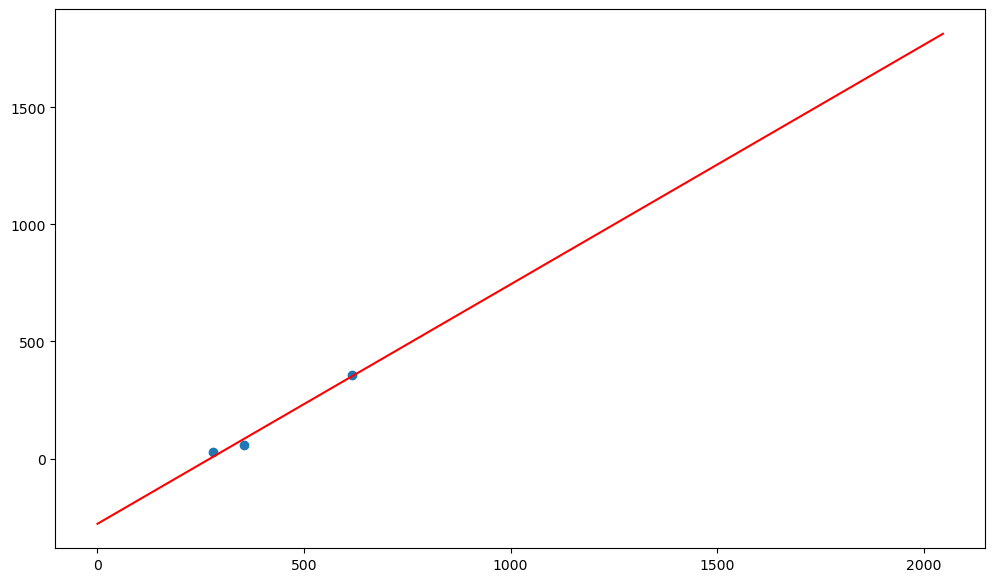

In [165]:
plt.figure(figsize=[12,7])
plt.scatter(channel, energy);
plt.plot(channels,lin_y, c='r');

In [22]:
data, channels = SpecPlot.read_file(dic['Americium']['File'])

NameError: name 'dic' is not defined

In [150]:
guesses = [280, 5, 20, 1,1,1]
b , e = roi['Americium']['26.34']['Limits']
data_corr = data['counts']-bg_data['counts']*(dic['Americium']['Time']/bg_time)
popt, pcov = opt.curve_fit(gauss_poly_model, channels[b:e], data_corr[b:e], p0=guesses)

In [151]:
y_model = gauss_poly_model(channels[b-20:e+20], popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])

array([ 2.79233782e+02, -2.89015562e+00, -1.61672535e+02, -1.19038033e-02,
        6.61468155e+00, -9.15818739e+02])

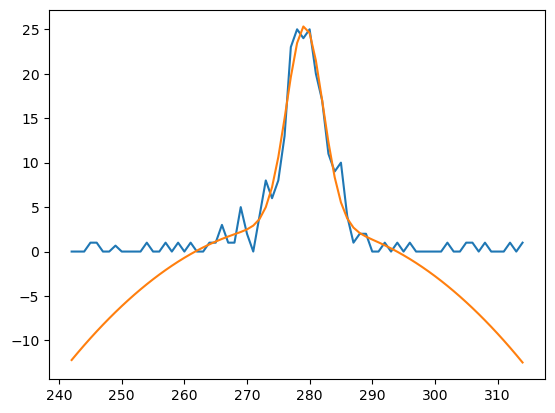

In [152]:
plt.plot(channels[b-20:e+20], data_corr[b-20:e+20]);
plt.plot(channels[b-20:e+20], y_model)
popt
#plt.plot(channels, data_corr)